## Table of Contents
1. [Introduction](#Introduction)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Modeling](#Modeling)
4. [Results](#Results)
5. [Conclusion](#Conclusion)


## Introduction

In [61]:
#importing required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [35]:
#reading the data

df=pd.read_csv("data/zomato_df_final_data.csv")

In [36]:
#inspect the first few rows of the data

print(df.head())



                                             address   cost  \
0                      371A Pitt Street, CBD, Sydney   50.0   
1      Shop 7A, 2 Huntley Street, Alexandria, Sydney   80.0   
2   Level G, The Darling at the Star, 80 Pyrmont ...  120.0   
3   Sydney Opera House, Bennelong Point, Circular...  270.0   
4              20 Campbell Street, Chinatown, Sydney   55.0   

                                       cuisine        lat  \
0   ['Hot Pot', 'Korean BBQ', 'BBQ', 'Korean'] -33.876059   
1  ['Cafe', 'Coffee and Tea', 'Salad', 'Poké'] -33.910999   
2                                 ['Japanese'] -33.867971   
3                        ['Modern Australian'] -33.856784   
4                            ['Thai', 'Salad'] -33.879035   

                                                link         lng  \
0    https://www.zomato.com/sydney/sydney-madang-cbd  151.207605   
1  https://www.zomato.com/sydney/the-grounds-of-a...  151.193793   
2        https://www.zomato.com/sydney/sokyo-pyrmo

In [37]:
#check all the column names

print(df.columns)

Index(['address', 'cost', 'cuisine', 'lat', 'link', 'lng', 'phone',
       'rating_number', 'rating_text', 'subzone', 'title', 'type', 'votes',
       'groupon', 'color', 'cost_2', 'cuisine_color'],
      dtype='object')


## Exploratory Data Analysis

In [38]:
#checking the numerical and categorical variables

num_var=df.select_dtypes(include="number").columns
cat_var=df.select_dtypes(exclude="number").columns

print(num_var)
print(cat_var)

Index(['cost', 'lat', 'lng', 'rating_number', 'votes', 'cost_2'], dtype='object')
Index(['address', 'cuisine', 'link', 'phone', 'rating_text', 'subzone',
       'title', 'type', 'groupon', 'color', 'cuisine_color'],
      dtype='object')


In [39]:
#checking for the NA values

print(df.isna().sum())

address             0
cost              346
cuisine             0
lat               192
link                0
lng               192
phone               0
rating_number    3316
rating_text      3316
subzone             0
title               0
type               48
votes            3316
groupon             0
color               0
cost_2            346
cuisine_color       0
dtype: int64


In [40]:
#detecting outliers in data

#list of numerical variables
numerical_cols=df[num_var]

#loop through each numerical columns to detect outliers

for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3-Q1

    #define the bound for ouliers
    lower_bound= Q1 - 1.5*IQR
    upper_bound= Q3 + 1.5*IQR

    #outlier
    outliers=df[(df[col] < lower_bound) | (df[col]> upper_bound)]

    print(f"Outliers in {col}:")
    print(outliers)
    print("\n")

Outliers in cost:
                                                 address   cost  \
2       Level G, The Darling at the Star, 80 Pyrmont ...  120.0   
3       Sydney Opera House, Bennelong Point, Circular...  270.0   
5              46 Kensington Street, Chippendale, Sydney  150.0   
6                             3 Bridge Lane, CBD, Sydney  120.0   
8       The Rocks Centre, 12 Argyle Street, The Rocks...  125.0   
...                                                  ...    ...   
9860    Kareela Golf & Social Club, 1 Bates Drive, Ka...  135.0   
9946        Shop 217B Castle Towers, Castle Hill, Sydney  120.0   
10125   The Hydro Majestic, 52-88 Great Western Highw...  170.0   
10174   Shop 10.41, World Square Shopping Centre, 680...  120.0   
10322   The Hydro Majestic, 52-88 Great Western Highw...  160.0   

                                                 cuisine        lat  \
2                                           ['Japanese'] -33.867971   
3                                  

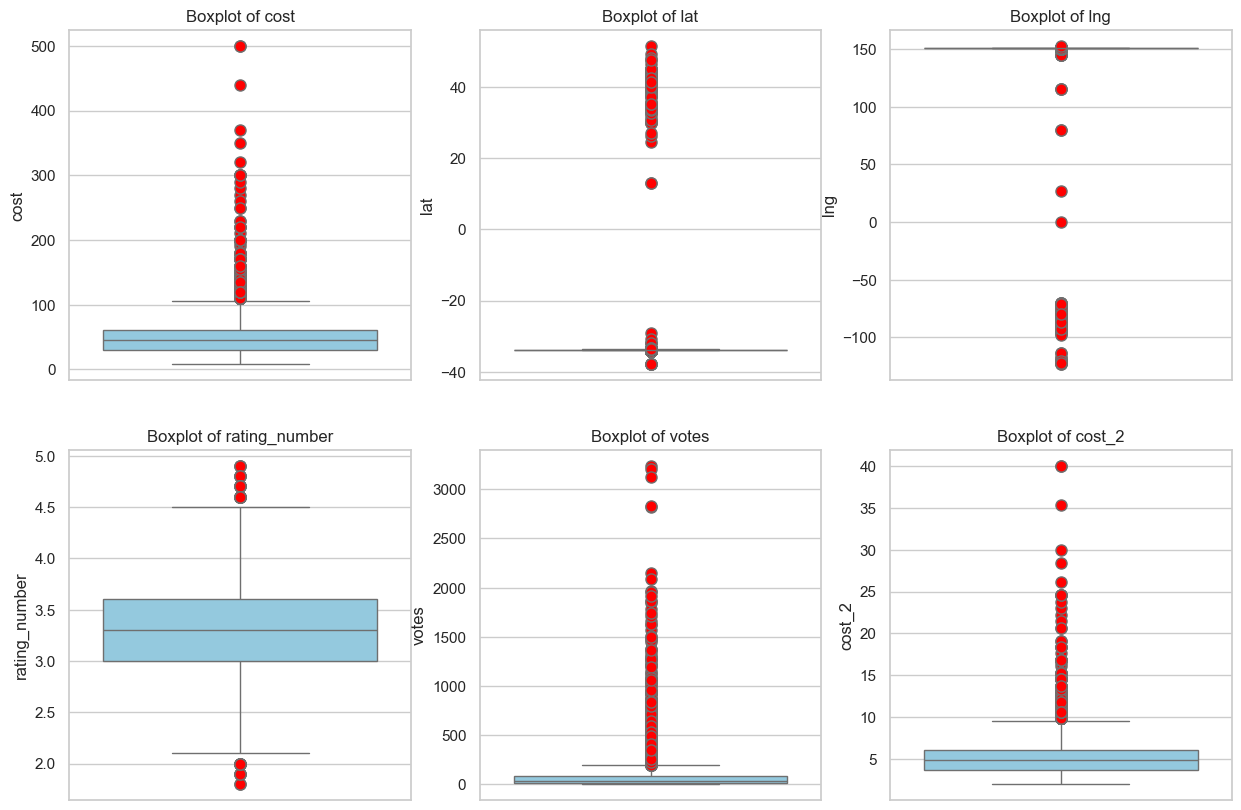

In [41]:
#visualizing outliers sing boxplot 

#creating subplot axes
nrows=2
ncols=3
fig, axes =plt.subplots(nrows,ncols, figsize=(15,10))

# Flatten the axes array to make it easier to iterate over
axes = axes.flatten()

# use to set style of background of plot
sns.set(style="whitegrid")

# Define properties for the outliers (fliers)
flierprops = dict(marker='o', markerfacecolor='red', markersize=8, linestyle='none')


for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i], color="skyblue",flierprops=flierprops)
    axes[i].set_title(f'Boxplot of {col}')

plt.tight_layout
plt.show()


#### How many unique cuisines are served by Sydney restaurants?

In [42]:
# Ensure the 'cuisine' column is of string type
df['cuisine'] = df['cuisine'].astype(str)

# Now clean and split the cuisines
df['cuisine'] = df['cuisine'].str.strip("[]").str.replace("'", "").str.split(',')

# Use explode to flatten the list of cuisines into individual rows
df_exploded = df.explode('cuisine')

# Strip whitespace from cuisine names and count unique cuisines
df_exploded['cuisine'] = df_exploded['cuisine'].str.strip()
unique_cuisines = df_exploded['cuisine'].nunique()

# Optional: List the unique cuisines
cuisine_list = df_exploded['cuisine'].unique()

print(f"There are {unique_cuisines} unique cuisines served by Sydney restaurants.")


There are 134 unique cuisines served by Sydney restaurants.


In [43]:
cuisine_counts=df_exploded["cuisine"].value_counts()

C:\Users\rohit\AppData\Local\Temp\ipykernel_8008\3907037235.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=cuisine_counts.index[:25], x=cuisine_counts.values[:25],palette=colors)


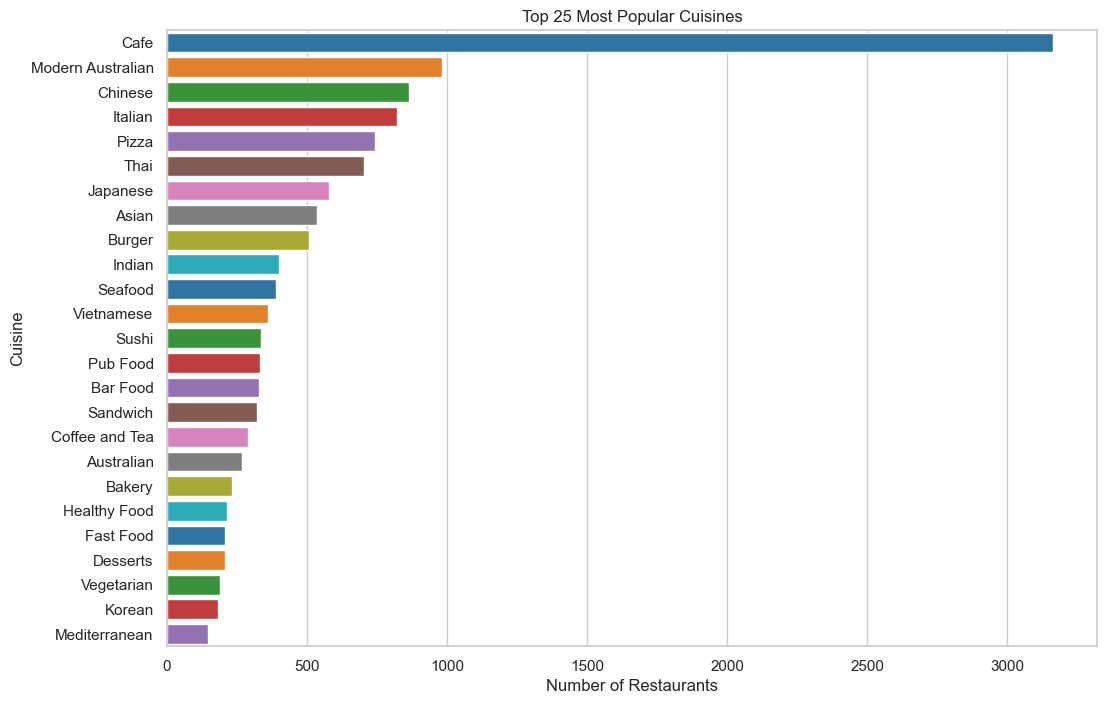

In [44]:
#plottong the top 15 cuisines offered by sydney restaurants

plt.figure(figsize=(12, 8))
colors = sns.color_palette("tab10", n_colors=25)
sns.barplot(y=cuisine_counts.index[:25], x=cuisine_counts.values[:25],palette=colors)  
plt.title('Top 25 Most Popular Cuisines')
plt.xlabel('Number of Restaurants')
plt.ylabel('Cuisine')
plt.show()

#### Which suburbs (top 3) have the highest number of restaurants?

In [45]:
# Define a function to extract the suburb from the address
def extract_suburb(address):
    parts = address.split(',')
    if len(parts) >= 2:
        return parts[-2].strip()  # Return the second-to-last part, which is usually the suburb
    else:
        return None  # In case the address format is unusual

# Apply the function to extract suburbs
df['suburb'] = df['address'].apply(extract_suburb)

# Now count the number of restaurants by suburb
suburbs = df['suburb'].value_counts()

print("Suburbs with the number of restaurants")
print(suburbs)



Suburbs with the number of restaurants
suburb
CBD                       651
Parramatta                268
Darlinghurst              189
Chatswood                 174
Newtown                   159
                         ... 
527 Harris Street           1
Shop 3/127 Forest Road      1
3/33 Terminus Street        1
77 York Street              1
Jordan Springs              1
Name: count, Length: 1035, dtype: int64


C:\Users\rohit\AppData\Local\Temp\ipykernel_8008\3547081812.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=suburbs.index[:3],y=suburbs.values[:3],palette="tab10")


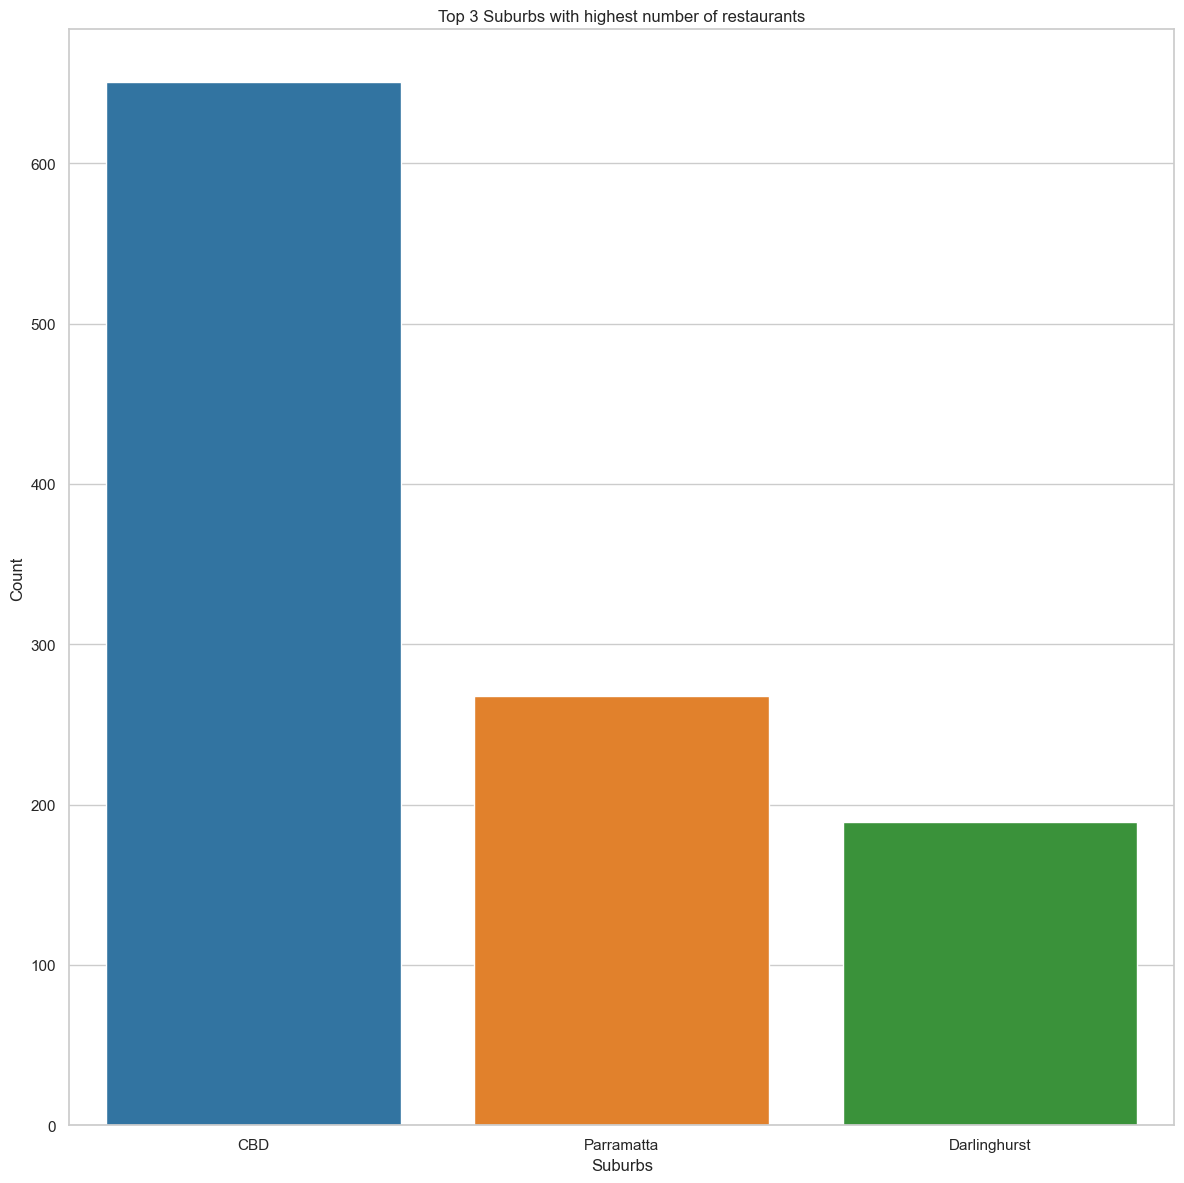

In [46]:
#visualizing the top 3 suburbs
plt.figure(figsize=(12,12))
sns.barplot(x=suburbs.index[:3],y=suburbs.values[:3],palette="tab10")
plt.title("Top 3 Suburbs with highest number of restaurants")
plt.xlabel("Suburbs")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#### “Restaurants with ‘excellent’ ratings are mostly costly while those with ‘Poor’ ratings are rarely expensive”.

To answer this if the above statement is true or not, first we will make a boxplot to see the cost distribution for each rating category.

C:\Users\rohit\AppData\Local\Temp\ipykernel_8008\315812483.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['rating_text'], y=df['cost'], palette="tab10")


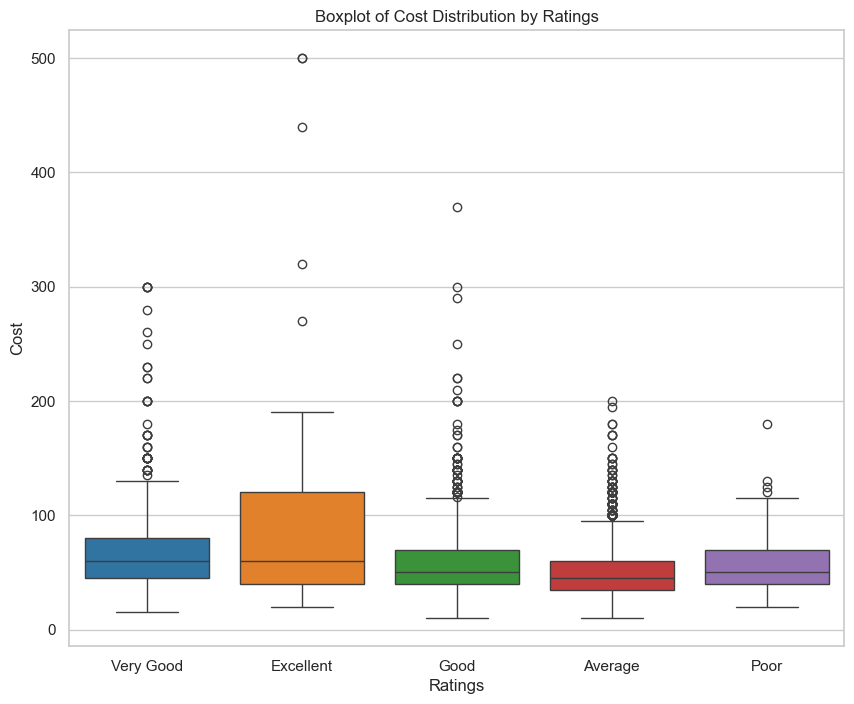

In [47]:
plt.figure(figsize=(10,8))

# Create a boxplot to show the distribution of costs by rating
sns.boxplot(x=df['rating_text'], y=df['cost'], palette="tab10")

plt.xlabel("Ratings")
plt.ylabel("Cost")
plt.title("Boxplot of Cost Distribution by Ratings")
plt.show()


#### Key observations:

-"**Excellent**" ratings: These restaurants tend to have a higher median cost, with the boxplot showing that many of these restaurants fall in the higher cost range. The interquartile range (IQR) is higher compared to other ratings, indicating that restaurants with "Excellent" ratings tend to be more expensive on average.There are outliers above 200, indicating some restaurants with "Excellent" ratings have very high costs, with some reaching around 500. 

-"**Poor**" ratings:The median cost for "Poor" rated restaurants is 50, which is higher than "Average" rated restaurants.The IQR is slightly larger compared to "Average" rated restaurants, meaning there’s more cost variation among "Poor" rated restaurants.A few outliers show some "Poor" rated restaurants can have higher costs, but most are still relatively affordable.

-"**Very Good**" ratings:The median cost for "Very Good" rated restaurants is lower than "Excellent" rated ones.The IQR is smaller, indicating less variation in restaurant costs. The box is mostly concentrated below 100, suggesting that most "Very Good" rated restaurants are moderately priced.There are fewer outliers compared to "Excellent" rated restaurants, but still a few higher-cost restaurants in this category.

-"**Good**" ratings:The median cost is lower than "Very Good" and "Excellent" but still close to 50.The IQR is small, indicating that most "Good" rated restaurants are affordable, with costs primarily under 100.There are a few outliers above 200, but most restaurants are in a lower price range.

-"**Average**" ratings:The median cost is close to 45, making it one of the lower-cost categories.The IQR is small, meaning that there’s little variation in the cost for "Average" rated restaurants.There are a few outliers, but the majority of restaurants are in the affordable range, under 100.

To further quantify, we can create a summary statistics: 

In [48]:
# Summary statistics for each rating category
cost_summary = df.groupby('rating_text')['cost'].agg(["mean","median"])

print("Median cost per rating category:")
print(cost_summary)


Median cost per rating category:
                   mean  median
rating_text                    
Average       51.021267    45.0
Excellent    101.666667    60.0
Good          59.528114    50.0
Poor          55.845771    50.0
Very Good     71.515810    60.0


Based on the boxplot and summary statistics, I agree with the statement. Restaurants with "Excellent" ratings are generally more expensive, as reflected by the higher median cost and the presence of more high-cost outliers. In contrast, "Poor" rated restaurants tend to have lower costs, with fewer high-cost outliers, supporting the idea that they are generally less expensive.


### Univariate Analysis

#### Cost Variable

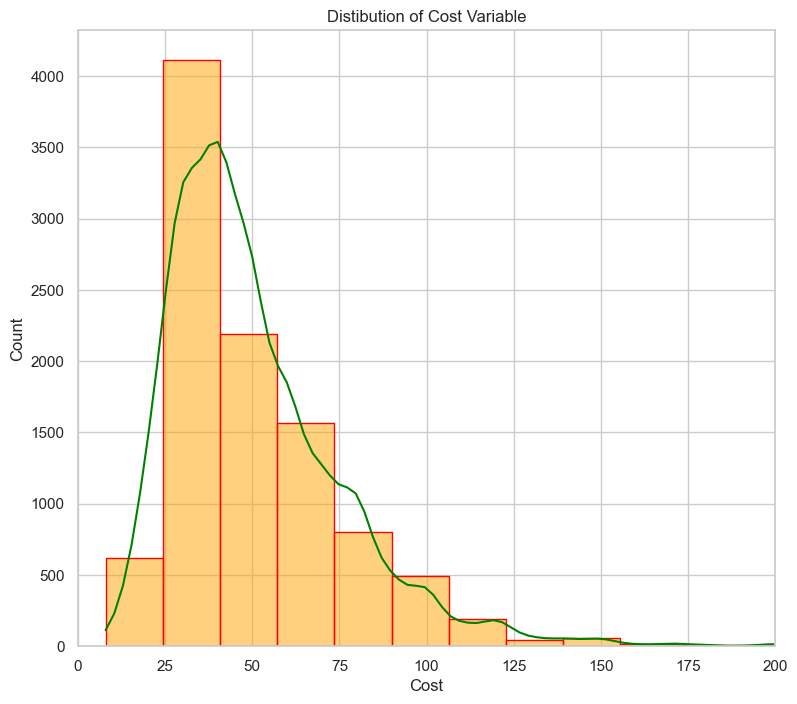

In [49]:
#creating histogram to see the distribution of the data
plt.figure(figsize=(9,8))
ax=sns.histplot(data=df,x="cost", bins=30, kde=True, color="orange",edgecolor="red")
ax.lines[0].set_color("green")
plt.title("Distibution of Cost Variable")
plt.xlabel("Cost")
plt.xlim(0, 200)
plt.show()

#### Key Interpretation:

- The histogram shows that the majority of restaurant costs are clustered between 20 and 50. 
- This can be observed from the tall bars in this range, with the highest peak around 25.
- The distribution is right-skewed, meaning there are fewer restaurants with higher costs (over 100), as indicated by the long tail on the right side.
- The green KDE curve (Kernel Density Estimate) overlays the histogram, providing a smooth representation of the probability density. It confirms that most restaurants have costs concentrated between 20 and 50.
- There are some outliers in the dataset, as seen from the bars on the right-hand side that go beyond 100, with a few even reaching as high as 200. This indicates a small proportion of restaurants with much higher costs, but they are very uncommon.

#### Rating Variable

C:\Users\rohit\AppData\Local\Temp\ipykernel_8008\277035686.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating_number', data=df, palette='Set2')


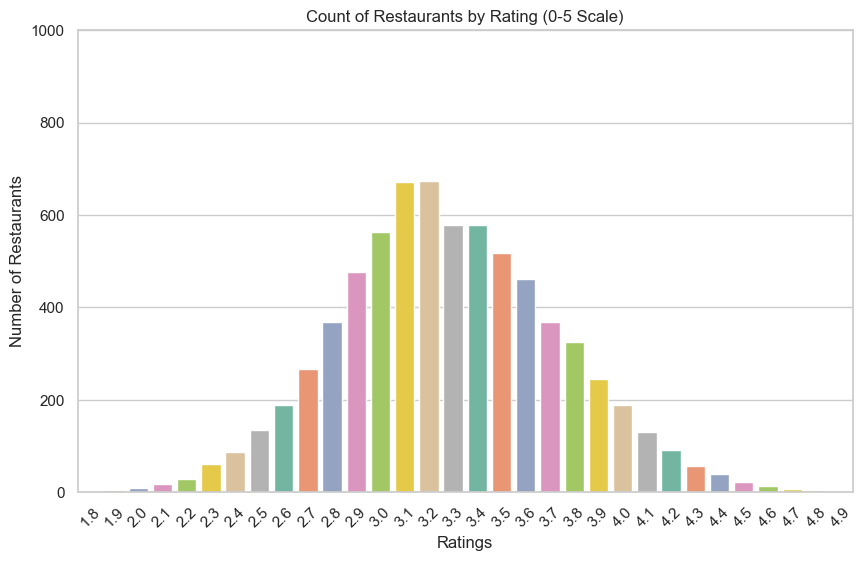

In [50]:

# Creating a countplot to show the count of each rounded rating number
plt.figure(figsize=(10, 6))
sns.countplot(x='rating_number', data=df, palette='Set2')
plt.title('Count of Restaurants by Rating (0-5 Scale)')
plt.xlabel('Ratings')
plt.ylabel('Number of Restaurants')
plt.ylim(0, 1000) 
plt.xticks(rotation=45)
plt.show()


#### Key Interpretation:

- Most restaurants are rated between 3.0 and 3.5, suggesting that the majority are considered average to slightly above average in quality.
- Extremely low or high ratings are relatively rare, meaning most restaurants avoid being rated as exceptionally bad or outstanding.
- This distribution shows that customer ratings tend to cluster around the middle, and it's harder for restaurants to achieve exceptional or very poor ratings.

#### Type Variable

In [51]:
print(df["type"].unique())

["['Casual Dining']" "['Café']" "['Fine Dining']" "['Fine Dining', 'Bar']"
 "['Casual Dining', 'Dessert Parlour']" "['Fine Dining', 'Wine Bar']"
 "['Casual Dining', 'Wine Bar']" "['Casual Dining', 'Bar']"
 "['Fast Food']" "['Café', 'Bakery']" "['Casual Dining', 'Café']"
 "['Bar']" "['Bakery', 'Dessert Parlour']" "['Bar', 'Wine Bar']"
 "['Food Court']" "['Dessert Parlour', 'Café']" "['Bar', 'Casual Dining']"
 "['Bakery', 'Pub']" "['Café', 'Casual Dining']" "['Café', 'Bar']"
 "['Casual Dining', 'Pub']" "['Bakery', 'Café']" "['Food Truck']"
 "['Café', 'Dessert Parlour']" "['Dessert Parlour']" "['Pub']" nan
 "['Pub', 'Casual Dining']" "['Dessert Parlour', 'Bakery']"
 "['Café', 'Wine Bar']" "['Pub', 'Wine Bar']"
 "['Food Court', 'Casual Dining']" "['Wine Bar', 'Casual Dining']"
 "['Casual Dining', 'Food Court']" "['Club', 'Bar']"
 "['Casual Dining', 'Bakery']" "['Bar', 'Pub']" "['Bar', 'Café']"
 "['Pub', 'Bar']" "['Beverage Shop']" "['Bakery']" "['Wine Bar']"
 "['Bar', 'Fine Dining']" "['Ca

In [52]:
df['type'] = df['type'].fillna("unknown")

In [53]:
# Ensure the 'cuisine' column is of string type
df['type'] = df['type'].astype(str)

# Now clean and split the cuisines
df['type'] = df['type'].str.strip("[]").str.replace("'", "").str.split(',')

# Use explode to flatten the list of cuisines into individual rows
df_exploded_2 = df.explode('type')

# Strip whitespace from cuisine names and count unique cuisines
df_exploded_2['type'] = df_exploded_2['type'].str.strip()
#unique_cuisines = df_exploded['cuisine'].nunique()

# Optional: List the unique cuisines
#cuisine_list = df_exploded['cuisine'].unique()

type_count=df_exploded_2["type"].value_counts()

C:\Users\rohit\AppData\Local\Temp\ipykernel_8008\2549718096.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=type_count.values[:10],y=type_count.index[:10],palette="tab10")


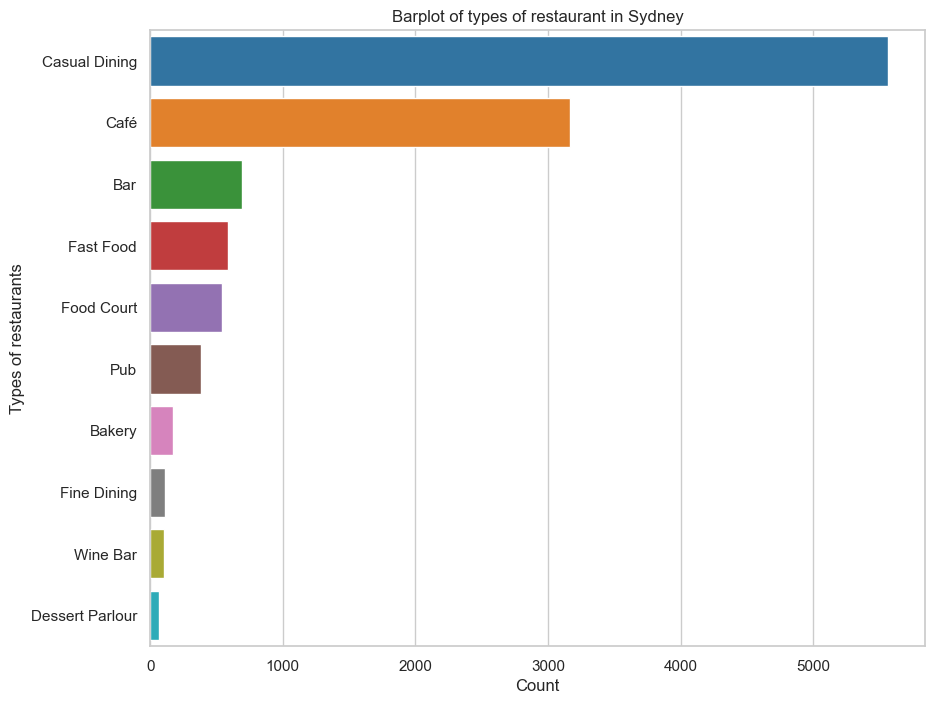

In [54]:
plt.figure(figsize=(10,8))
sns.barplot(x=type_count.values[:10],y=type_count.index[:10],palette="tab10")
plt.title("Barplot of types of restaurant in Sydney")
plt.xlabel("Count")
plt.ylabel("Types of restaurants")
plt.show()

## Modelling

#### Declare source and target variables

In [55]:
X=df.drop(["rating_text"], axis=1)
y=df["rating_number"]

#### Split the data into training and test set

In [56]:
#split X and y into training and test sets
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8400, 17) (8400,)
(2100, 17) (2100,)


### Feature Engineering

In [57]:
numerical_var=X_train.select_dtypes(include="number").columns
categorical_var=X_train.select_dtypes(exclude="number").columns

print(numerical_var)
print(categorical_var)

Index(['cost', 'lat', 'lng', 'rating_number', 'votes', 'cost_2'], dtype='object')
Index(['address', 'cuisine', 'link', 'phone', 'subzone', 'title', 'type',
       'groupon', 'color', 'cuisine_color', 'suburb'],
      dtype='object')


#### Engineering missing values in numerical variables

In [58]:
#checking for missing values in train set
print(X_train[numerical_var].isnull().sum())

cost              272
lat               147
lng               147
rating_number    2643
votes            2643
cost_2            272
dtype: int64


In [59]:
#checking for missing values in test set
print(X_test[numerical_var].isnull().sum())

cost              74
lat               45
lng               45
rating_number    673
votes            673
cost_2            74
dtype: int64


In [60]:
# percentage of missing values in each variable
print(round(X_train[numerical_var].isnull().mean(), 2))

cost             0.03
lat              0.02
lng              0.02
rating_number    0.31
votes            0.31
cost_2           0.03
dtype: float64


In [64]:
#imputaion of missing values with the median value

imputer = SimpleImputer(strategy="median")
X_train[numerical_var]=imputer.fit_transform(X_train[numerical_var])
X_test[numerical_var]=imputer.transform(X_test[numerical_var])

print("Result for training data in numerical variables")
print(X_train[numerical_var].isnull().sum())

print("Result for test data in numerical variables")
print(X_train[numerical_var].isnull().sum())


Result for training data
cost             0
lat              0
lng              0
rating_number    0
votes            0
cost_2           0
dtype: int64
Result for test data
cost             0
lat              0
lng              0
rating_number    0
votes            0
cost_2           0
dtype: int64


SimpleImputer with the median strategy has been used to handle missing values in the numerical columns. This approach ensures that missing values are replaced with the median calculated from the training data, which is robust to outliers.

I have fitted the imputer on the training data to avoid data leakage, meaning there is no use of any information from the test set while training. After fitting the imputer, same median values have been applied to both the training and test data, ensuring consistency in how missing values are handled.

#### Engineering missing values in categorical variables

In [65]:
round(X_train[categorical_var].isnull().mean(), 2)

address          0.00
cuisine          0.00
link             0.00
phone            0.00
subzone          0.00
title            0.00
type             0.00
groupon          0.00
color            0.00
cuisine_color    0.00
suburb           0.01
dtype: float64

In [66]:
imputer = SimpleImputer(strategy="most_frequent")
X_train[categorical_var]=imputer.fit_transform(X_train[categorical_var])
X_test[categorical_var]=imputer.transform(X_test[categorical_var])

print("Result for training data in categorical variables")
print(X_train[numerical_var].isnull().sum())

print("Result for test data in categorical variables")
print(X_train[numerical_var].isnull().sum())

TypeError: unhashable type: 'list'

SimpleImputer with the "most frequent" strategy was used to handle missing values in categorical variables. This filled missing values with the most commonly occurring category (mode) in each column.

The imputer was fitted on the training data and applied to both training and test sets, ensuring that the imputation was based on the training data only, preventing data leakage and maintaining consistency in handling missing values